In [3]:
!which python3

/usr/bin/python3


In [ ]:
!git status

# Colab

In [1]:
# For Colab
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append("/content/drive/MyDrive/portfolio-optimization/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/portfolio-optimization/

/content/drive/MyDrive/portfolio-optimization


# Importing libraries, models, datasets

In [5]:
from data import ohlcv_adjusted_mag7_data
from ml.dataset import StockDataset
from ml.models import sharpe_ratio_loss, SharpeLSTMModel, SharpeFCModel
import classic.mpt as mpt

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import json
from datetime import datetime
import random

In [7]:
# Run before importing torch. This is for cuda memory allocation error. Doesn't fix it tho.
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Fixing seed

In [10]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# TrainValTest splitting

In [11]:
# For Local and Colab
df = ohlcv_adjusted_mag7_data.get_close()

In [12]:
df.shape

(3287, 7)

In [13]:
# Train Data: 2006-2017
train_prices = df.loc[:'2018']

# Validation Data: 2018
val_prices = df.loc['2019']

# Test Data: 2019 onward
test_prices = df.loc['2020':]

In [14]:
train_returns = ((train_prices - train_prices.shift(1)) / train_prices.shift(1)).iloc[1:]
val_returns = ((val_prices - val_prices.shift(1)) / val_prices.shift(1)).iloc[1:]
test_returns = ((test_prices - test_prices.shift(1)) / test_prices.shift(1)).iloc[1:]

In [15]:
train_prices = train_prices.iloc[1:]
val_prices = val_prices.iloc[1:]
test_prices = test_prices.iloc[1:]

In [16]:
train_prices.shape, val_prices.shape, test_prices.shape

((1664, 7), (251, 7), (1369, 7))

In [17]:
train_returns.shape, val_returns.shape, test_returns.shape

((1664, 7), (251, 7), (1369, 7))

In [18]:
train_returns.describe()

,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NVDA
count,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000
mean,0.000641,0.001349,0.001581,0.000853,0.001012,0.000954,0.001765
std,0.015837,0.018896,0.020531,0.014456,0.023480,0.014635,0.023571
min,-0.123559,-0.109972,-0.137445,-0.080065,-0.189609,-0.113994,-0.187565
25%,-0.006871,-0.007552,-0.008976,-0.005940,-0.009289,-0.006105,-0.008997
50%,0.000474,0.000921,0.001296,0.000503,0.000886,0.000536,0.001371
75%,0.009047,0.011013,0.011646,0.008217,0.011832,0.007918,0.012299
max,0.081983,0.141311,0.147063,0.162587,0.296116,0.104521,0.298014


# Normalizing train and test

In [19]:
# Normalizing train and validation

# scaler_prices = MinMaxScaler(feature_range=(0, 1))
# scaler_returns = MinMaxScaler(feature_range=(-1, 1))

scaler_prices = StandardScaler()
scaler_returns = StandardScaler()

In [20]:
scaler_prices.fit(train_prices)
scaler_returns.fit(train_returns)

StandardScaler()

In [21]:
train_returns = scaler_returns.transform(train_returns)
train_prices = scaler_prices.transform(train_prices)

val_returns = scaler_returns.transform(val_returns)
val_prices = scaler_prices.transform(val_prices)

# test_returns = scaler_returns.transform(test_returns)
# test_prices = scaler_prices.transform(test_prices)

In [22]:
pd.DataFrame(train_prices).describe()

,0,1,2,3,4,5,6
count,1.664000e+03,1.664000e+03,1.664000e+03,1.664000e+03,1.664000e+03,1.664000e+03,1664.000000
mean,6.832142e-17,6.832142e-17,6.832142e-17,-2.732857e-16,-3.416071e-16,3.416071e-16,0.000000
std,1.000301e+00,1.000301e+00,1.000301e+00,1.000301e+00,1.000301e+00,1.000301e+00,1.000301
min,-1.445585e+00,-1.008239e+00,-1.279633e+00,-1.652527e+00,-1.535909e+00,-1.199920e+00,-0.771766
25%,-8.279974e-01,-7.931704e-01,-9.976214e-01,-6.822756e-01,-7.887147e-01,-7.771952e-01,-0.716916
50%,-1.765483e-01,-3.409671e-01,-1.152113e-01,-1.425848e-01,-8.703525e-02,-3.459975e-01,-0.624370
75%,6.697964e-01,5.290325e-01,1.045089e+00,8.708084e-01,8.028174e-01,5.486421e-01,0.503259
max,2.775202e+00,2.828515e+00,1.839675e+00,2.264511e+00,2.252590e+00,2.512561e+00,2.568096


# Dataloader construction

## Hyperparameters

In [68]:
B = 8 # batch size
R = 25 # sharpe window
T = 32 # window size
S = df.shape[1] # stock count
feature_count = 32 # feature count after first dense layer
H = 64 # hidden size
num_epochs = 100 # number of epochs

# # For saving model and plots
# model_name = "single_layer_lstm_on_mag7"
# run_id = datetime.now().strftime('%Y%m%d-%H%M')
# os.makedirs(run_id, exist_ok=True)

## Train and validation dataloaders

In [69]:
train_dataset = StockDataset(train_returns, train_prices, window_size=T, sharpe_window=R)
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

for batch_data, batch_returns in train_dataloader:
    print(batch_data.shape)
    print(batch_returns.shape)
    break
print("Length of train dataloader:", len(train_dataloader))

torch.Size([8, 25, 32, 7, 2])
torch.Size([8, 25, 7])
Length of train dataloader: 201


In [70]:
val_dataset = StockDataset(val_returns, val_prices, window_size=T, sharpe_window=R)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True)

for batch_data, batch_returns in val_dataloader:
    print(batch_data.shape)
    print(batch_returns.shape)
    break

print("Length of validation dataloader:", len(val_dataloader))

torch.Size([8, 25, 32, 7, 2])
torch.Size([8, 25, 7])
Length of validation dataloader: 25


In [71]:
# test_dataset = StockDataset(test_returns, test_prices[1:], window_size=T, sharpe_window=R)
# test_dataloader = DataLoader(test_dataset, batch_size=B, shuffle=True)

# for batch_data, batch_returns in test_dataloader:
#     print(batch_data.shape)
#     print(batch_returns.shape)
#     break

# print("Length of test dataloader:", len(test_dataloader))

# Models initialization

## LSTM

In [72]:
model = SharpeLSTMModel(num_classes=1, input_size=2, hidden_size=H, num_layers=1, feature_size=feature_count).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.99, weight_decay=1e-5)

## FC

In [73]:
model_fc = SharpeFCModel(input_size=2, hidden_size=H, feature_size=feature_count).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_fc = torch.optim.SGD(model_fc.parameters(), lr=1e-4, momentum=0.99, weight_decay=1e-5)

# Training

## LSTM

In [74]:
# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    for batch_data, batch_returns in train_dataloader:
        batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        weights = model(batch_data)

        # Compute training loss (Negative Sharpe ratio)
        train_loss = sharpe_ratio_loss(weights, batch_returns)
        total_train_loss += train_loss.item()

        # Backward pass
        train_loss.backward()

        # Update parameters
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)  # Average training loss for the epoch
    train_losses.append(avg_train_loss) # To plot after

    # Validation phase (after each epoch)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient calculation needed for validation
        total_val_loss = 0.0
        for batch_data, batch_returns in val_dataloader:
            batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

            # Forward pass (no gradients needed)
            weights = model(batch_data)

            # Compute validation loss (Negative Sharpe ratio)
            val_loss = sharpe_ratio_loss(weights, batch_returns)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)  # Average validation loss for the epoch
        val_losses.append(avg_val_loss)

    # Print training and validation loss for the current epoch
    print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.6f}, Validation Loss = {avg_val_loss:.6f}")

Epoch 1: Training Loss = -0.025545, Validation Loss = -0.056789
Epoch 2: Training Loss = -0.025638, Validation Loss = -0.056135
Epoch 3: Training Loss = -0.025749, Validation Loss = -0.058547
Epoch 4: Training Loss = -0.025865, Validation Loss = -0.054782
Epoch 5: Training Loss = -0.025982, Validation Loss = -0.060307
Epoch 6: Training Loss = -0.026102, Validation Loss = -0.057562
Epoch 7: Training Loss = -0.026222, Validation Loss = -0.055329
Epoch 8: Training Loss = -0.026345, Validation Loss = -0.059123
Epoch 9: Training Loss = -0.026472, Validation Loss = -0.053790
Epoch 10: Training Loss = -0.026597, Validation Loss = -0.057590
Epoch 11: Training Loss = -0.026731, Validation Loss = -0.059201
Epoch 12: Training Loss = -0.026864, Validation Loss = -0.055081
Epoch 13: Training Loss = -0.027001, Validation Loss = -0.059633
Epoch 14: Training Loss = -0.027141, Validation Loss = -0.047490
Epoch 15: Training Loss = -0.027288, Validation Loss = -0.055388
Epoch 16: Training Loss = -0.02743

## FC

In [75]:
# Training loop using model_fc and optimizer_fc
train_losses_fc = []
val_losses_fc = []
for epoch in range(num_epochs):
    model_fc.train()  # Set model_fc to training mode
    total_train_loss = 0.0
    for batch_data, batch_returns in train_dataloader:
        batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

        optimizer_fc.zero_grad()  # Reset gradients for model_fc

        # Forward pass
        weights = model_fc(batch_data)

        # Compute training loss (Negative Sharpe ratio)
        train_loss = sharpe_ratio_loss(weights, batch_returns)
        total_train_loss += train_loss.item()

        # Backward pass
        train_loss.backward()

        # Update parameters
        optimizer_fc.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses_fc.append(avg_train_loss)

    # Validation phase
    model_fc.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for batch_data, batch_returns in val_dataloader:
            batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

            # Forward pass
            weights = model_fc(batch_data)

            # Compute validation loss (Negative Sharpe ratio)
            val_loss = sharpe_ratio_loss(weights, batch_returns)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses_fc.append(avg_val_loss)

    # Print losses
    print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.6f}, Validation Loss = {avg_val_loss:.6f}")


Epoch 1: Training Loss = -0.025183, Validation Loss = -0.057452
Epoch 2: Training Loss = -0.025207, Validation Loss = -0.056396
Epoch 3: Training Loss = -0.025263, Validation Loss = -0.053234
Epoch 4: Training Loss = -0.025237, Validation Loss = -0.056469
Epoch 5: Training Loss = -0.025265, Validation Loss = -0.059092
Epoch 6: Training Loss = -0.025315, Validation Loss = -0.057869
Epoch 7: Training Loss = -0.025299, Validation Loss = -0.060427
Epoch 8: Training Loss = -0.025240, Validation Loss = -0.058617
Epoch 9: Training Loss = -0.025271, Validation Loss = -0.050274
Epoch 10: Training Loss = -0.025335, Validation Loss = -0.057990
Epoch 11: Training Loss = -0.025331, Validation Loss = -0.056653
Epoch 12: Training Loss = -0.025435, Validation Loss = -0.059789
Epoch 13: Training Loss = -0.025417, Validation Loss = -0.060640
Epoch 14: Training Loss = -0.025328, Validation Loss = -0.057835
Epoch 15: Training Loss = -0.025424, Validation Loss = -0.058561
Epoch 16: Training Loss = -0.02547

## Train and validation losses plots

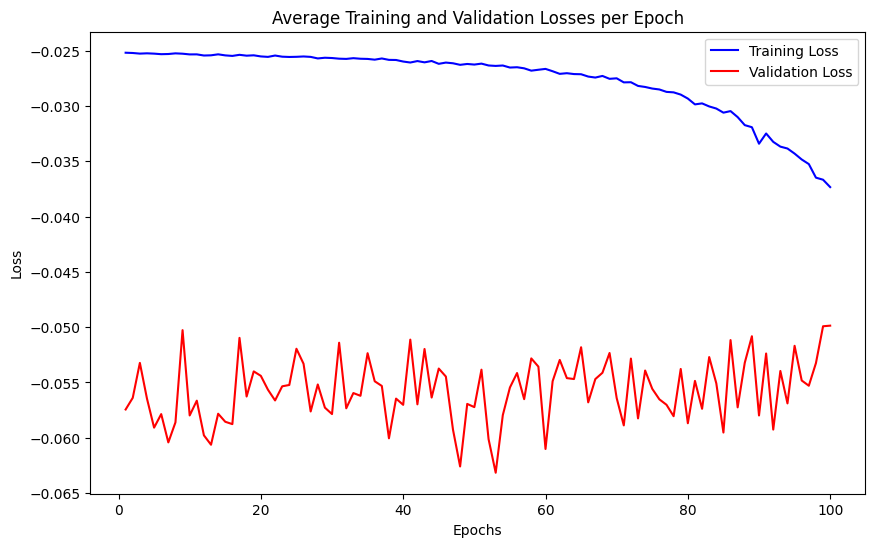

In [76]:
# Plotting train losses per epoch LSTM
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Losses per Epoch, LSTM")
plt.legend()

# # Saving plot
# plt.savefig(f"{run_id}/train_val_loss")

plt.show()

In [ ]:
# Plotting train losses per epoch FC
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses_fc, label="Training Loss", color='blue')
plt.plot(range(1, num_epochs + 1), val_losses_fc, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Losses per Epoch, FC")
plt.legend()

# # Saving plot
# plt.savefig(f"{run_id}/train_val_loss_fc")

plt.show()

## Pure Markowitz

In [77]:
# Portfolio value tracking
portfolio_value_markowitz = [1]  # Start with 1

markowitz_returns = []

# Rolling window Markowitz portfolio simulation
window_size = T  # Use past T days of returns

for t in range(window_size, len(test_returns)):

    if t == T:
        print(f"Day {t}")
    elif t % 100 == 0:
        print(f"Day {t}")
    elif t == test_prices.shape[0] - 1:
        print(f"Day {t}")

    # Get Markowitz optimal weights from our weight array
    optimal_weights = mpt.markowitz_optimization_cupy(test_returns.iloc[t-window_size:t], learning_rate=1e-3, max_iter=1000)

    # Convert to NumPy array
    optimal_weights = optimal_weights.get()
    # optimal_weights = optimal_weights.cpu().detach().numpy()


    # Compute portfolio return on day 101
    next_day_return = np.dot(optimal_weights, np.array(test_returns.iloc[t]))

    # print(f"Weights: {optimal_weights}")
    # print(f"Day {t} return: {next_day_return}")

    # Update portfolio value
    portfolio_value_markowitz.append(portfolio_value_markowitz[-1] * (1 + next_day_return))

    markowitz_returns.append(next_day_return)

# Convert to numpy array for easier plotting
portfolio_value_markowitz = np.array([x.get() if hasattr(x, 'get') else x for x in portfolio_value_markowitz])

Day 32
Day 100
Day 200
Day 300
Day 400
Day 500
Day 600
Day 700
Day 800
Day 900
Day 1000
Day 1100
Day 1200
Day 1300
Day 1368


## Saving Model


In [78]:
# Saving model weights
torch.save(model.state_dict(), f"{run_id}/weights.pth")

NameError: name 'run_id' is not defined

In [ ]:
# Saving model metadata
metadata = {
    "model": model_name,
    "B": B,
    "R": R,
    "T": T,
    "S": S,
    "feature_count": feature_count,
    "H": H,
    "num_epochs": num_epochs,
    "optimizer": "SGD",
    "loss_function": "SharpeRatioLoss",
    "notes": "FC-ReLU-LSTM-FC-Softmax. Predicting weights not returns yet. Smth is off with Markowitz."
}


with open(f"{run_id}/info.json", 'w') as f:
    json.dump(metadata, f, indent=4)

# Load saved models

In [46]:
model.load_state_dict(torch.load('20250617-0221/weights.pth'))

RuntimeError: Error(s) in loading state_dict for SharpeLSTMModel:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 32]) from checkpoint, the shape in current model is torch.Size([256, 32]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([256, 64]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 64]).

# Testing

In [79]:
cumulative_returns_test = [1]
cumulative_returns_equal = [1] # equal
cumulative_returns_fc = [1] # fc

test_predictions = []
benchmark_returns = []
test_predictions_fc = []

testing_data = torch.stack([torch.tensor(test_prices.values, dtype=torch.float32),
                            torch.tensor(test_returns.values, dtype=torch.float32)], axis=2).to(device) # (days, S, 2)
testing_returns = torch.tensor(test_returns.values, dtype=torch.float32).to(device)

print(f"testing_data: {testing_data.shape}, testing_returns: {testing_returns.shape}")
model.eval()
with torch.no_grad():
    for t in range(T, testing_data.shape[0]):
        weights = model(testing_data[t - T:t].reshape(1, 1, T, S, 2)) # (T, S, 2) -> (S) LSTM
        weights_equal = (torch.ones(S) / S).to(device) # equal
        weights_fc = model_fc(testing_data[t - T:t].reshape(1, 1, T, S, 2)) # (T, S, 2) -> (S) FC

        next_day_return = weights @ testing_returns[t] # lstm
        next_day_return_equal = weights_equal @ testing_returns[t] # equal
        next_day_return_fc = weights_fc @ testing_returns[t] # fc

        cumulative_returns_test.append(cumulative_returns_test[-1] * (1 + next_day_return))
        cumulative_returns_equal.append(cumulative_returns_equal[-1] * (1 + next_day_return_equal)) # equal
        cumulative_returns_fc.append(cumulative_returns_fc[-1] * (1 + next_day_return_fc)) # fc

        test_predictions.append(next_day_return.cpu())
        benchmark_returns.append(next_day_return_equal.cpu())
        test_predictions_fc.append(next_day_return_fc.cpu())

testing_data: torch.Size([1369, 7, 2]), testing_returns: torch.Size([1369, 7])


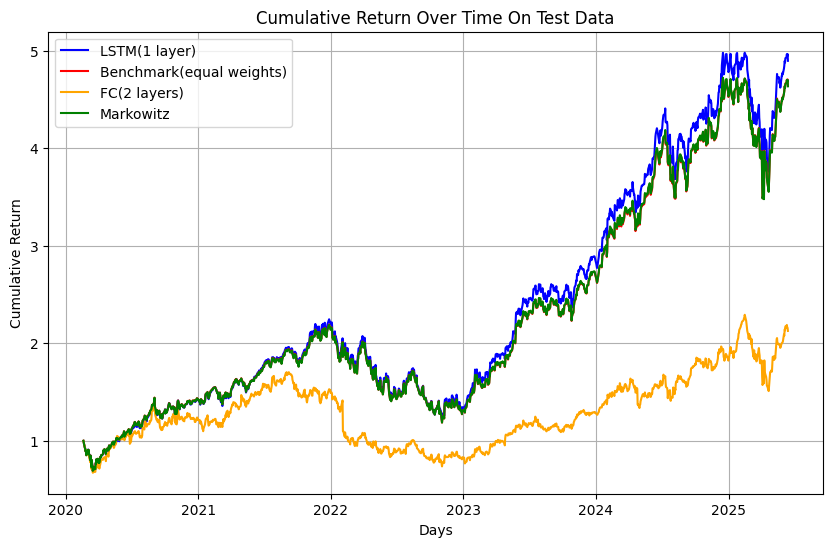

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(test_prices.index.values[T - 1:], np.array([r.cpu().item() if r != 1 else r for r in cumulative_returns_test]),
         label='LSTM(1 layer)', color='blue')
plt.plot(test_prices.index.values[T - 1:], np.array([r.cpu() if r != 1 else r for r in cumulative_returns_equal]),
         label='Benchmark(equal weights)', color='red') # equal
plt.plot(test_prices.index.values[T - 1:], np.array([r.cpu().item() if r != 1 else r for r in cumulative_returns_fc]),
         label='FC(4 layers)', color='orange')
plt.plot(test_prices.index.values[T - 1:], portfolio_value_markowitz,
         label='Markowitz', color='green') # markowitz
plt.title("Cumulative Return Over Time On Test Data")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)

# # Saving plot
# plt.savefig(f"{run_id}/test_cum_ret")

plt.show()

## Metrics

In [81]:
test_predictions = np.array(test_predictions)
benchmark_returns = np.array(benchmark_returns)
markowitz_returns = np.array(markowitz_returns)
test_predctions_fc = np.array(test_predictions_fc)

In [82]:
def compute_metrics(returns, cumulative_returns, risk_free_rate=0.0):
    # Expected Return
    expected_return = (cumulative_returns[-1] ** (252 / len(cumulative_returns)) - 1).item()
    # expected_return = cumulative_returns[-1].item() - 1

    # Standard Deviation
    std_dev = np.std(returns) * np.sqrt(252)

    # Downside Deviation
    downside_deviation = np.std(returns[returns < risk_free_rate]) * np.sqrt(252)

    # Sharpe Ratio
    sharpe_ratio = (expected_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan

    # Sortino Ratio
    sortino_ratio = (expected_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

    # Max Drawdown
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    max_drawdown = np.min(drawdown)

    # Assemble metrics
    metrics = {
        "Expected Return": expected_return,
        "STD": std_dev,
        "Downside Deviation": downside_deviation,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Maximum Drawdown": max_drawdown
    }

    return metrics


metrics_model = compute_metrics(test_predictions, cumulative_returns_test)
metrics_benchmark = compute_metrics(benchmark_returns, cumulative_returns_equal)
metrics_markowitz = compute_metrics(markowitz_returns, portfolio_value_markowitz)
metrics_fc = compute_metrics(test_predctions_fc, cumulative_returns_fc)

metrics_df = pd.DataFrame({
    "LSTM": metrics_model,
    "Benchmark": metrics_benchmark,
    "Markowitz": metrics_markowitz,
    "FC": metrics_fc
})

metrics_df

,LSTM,Benchmark,Markowitz,FC
Expected Return,0.348817,0.335172,0.334947,0.152767
STD,0.327436,0.323998,0.323911,0.362447
Downside Deviation,0.235462,0.234014,0.233699,0.272450
Sharpe Ratio,1.065299,1.034489,1.034071,0.421488
Sortino Ratio,1.481415,1.432273,1.433240,0.560717
Maximum Drawdown,-0.544032,-0.545878,-0.544561,-0.740630


# Junk

In [ ]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached:    {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Allocated: 0.24 GB
Cached:    0.25 GB


In [ ]:
torch.cuda.empty_cache()

In [ ]:
(torch.ones(S) / S)[0]

tensor(0.0020)